# Mie Scattering Efficiencies

**Scott Prahl**

**Mar 2021, Version 5**

*If RigolWFM is not installed, uncomment the following cell (i.e., delete the #) and run (shift-enter)*

In [1]:
#!pip install --user miepython

In [2]:
import numpy as np
import matplotlib.pyplot as plt

try:
    import miepython

except ModuleNotFoundError:
    print('miepython not installed. To install, uncomment and run the cell above.')
    print('Once installation is successful, rerun this cell again.')

When a monochromatic plane wave is incident on a sphere, it scatters and absorbs light depending on the properties of the light and sphere.  The sphere has radius $r$ and index of refraction $m=m_\mathrm{re}- j\,m_\mathrm{im}$.  The sphere size parameter $x=2\pi x/\lambda$ where $\lambda$ is the wavelength of the plane wave in a vacuum.

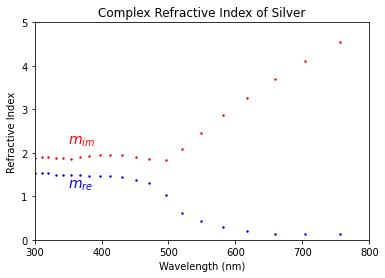

In [3]:
# import the Johnson and Christy data for silver
ag = np.genfromtxt('https://refractiveindex.info/tmp/data/main/Au/Johnson.txt', delimiter='\t')

# data is stacked so need to rearrange
N = len(ag)//2
ag_lam = ag[1:N,0]
ag_mre = ag[1:N,1]
ag_mim = ag[N+1:,1]

plt.scatter(ag_lam*1000,ag_mre,s=2,color='blue')
plt.scatter(ag_lam*1000,ag_mim,s=2,color='red')
plt.xlim(300,800)
plt.ylim(0,5)

plt.xlabel('Wavelength (nm)')
plt.ylabel('Refractive Index')
plt.text(350, 1.2, '$m_{re}$', color='blue', fontsize=14)
plt.text(350, 2.2, '$m_{im}$', color='red', fontsize=14)

plt.title('Complex Refractive Index of Silver')

plt.show()

## Cross Sections

The geometric cross section of a sphere of radius $r$ is just

$$
G = \pi r^2
$$

The scattering cross section $\sigma_\mathrm{sca}$ is area of a the incident plane wave that results in scattered light.  

Since some of the incident light may be absorbed (i.e., $m_\mathrm{im}>0$) then there is also an area of the incident wave that is absorbed $\sigma_\mathrm{abs}$.  Finally, the total extinction cross section is just the sum of both

$$
\sigma_\mathrm{ext} = \sigma_\mathrm{abs}+\sigma_\mathrm{sca}
$$

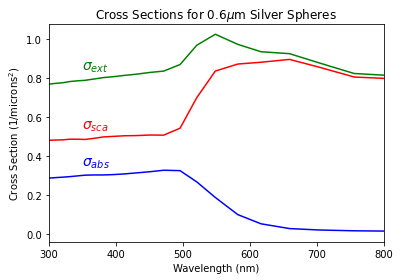

In [4]:
r = 0.3  #radius in microns

x = 2*np.pi*r/ag_lam;
m = ag_mre - 1.0j * ag_mim
qext, qsca, qback, g = miepython.mie(m,x)
absorb  = (qext - qsca) * np.pi * r**2
scatt   = qsca * np.pi * r**2
extinct = qext* np.pi * r**2

plt.plot(ag_lam*1000,absorb,color='blue')
plt.plot(ag_lam*1000,scatt,color='red')
plt.plot(ag_lam*1000,extinct,color='green')
plt.text(350, 0.35,'$\sigma_{abs}$', color='blue', fontsize=14)
plt.text(350, 0.54,'$\sigma_{sca}$', color='red', fontsize=14)
plt.text(350, 0.84,'$\sigma_{ext}$', color='green', fontsize=14)

plt.xlabel("Wavelength (nm)")
plt.ylabel("Cross Section (1/microns$^2$)")
plt.title("Cross Sections for %.1f$\mu$m Silver Spheres" % (r*2))

plt.xlim(300,800)
plt.show()

The scattering cross section may be related to the transmission of a beam 
through a dispersion of scatterers of equal size.  For $\rho$ particles per
unit volume, the attenuation due to scattering is

$$
-\frac{dI}{dx} = \rho \sigma_{\hbox{sca}} I
$$

The transmission is

$$
T = I/I_0 = \exp(-\rho \sigma_{\hbox{sca}} x) = \exp(-\mu_s x)
$$

or

$$
\mu_s = \rho \sigma_{\hbox{sca}} = \rho \pi r_0^2 Q_{\hbox{sca}}
$$

[Kerker, p. 38](https://www.sciencedirect.com/book/9780124045507/the-scattering-of-light-and-other-electromagnetic-radiation).

## Backscattering Cross Section

For plane-wave radiation incident on a scattering object or a scattering medium, the ratio of the intensity [W/sr] scattered in the direction toward the source to the incident irradiance [W/area].

1. So defined, the backscattering cross section has units of area per unit solid angle.

2. In common usage, synonymous with radar cross section, although this can be confusing because the radar cross section is $4\pi$ times the backscattering cross section as defined above and has units of area.

If $Q_{sca}$ [unitless] is the backscattering efficiency then the scattering cross section $C_{sca}$ [area]

$$
C_{sca} = \pi a^2 Q_{sca}
$$

Thus if $Q_{back}$ [unitless] is the backscattering efficiency then the scattering cross section $C_{back}$ [area]

$$
C_{back} = \pi a^2 Q_{back}
$$

Now the phase function is normalized so that ($S_1(\theta)$ has units of sr$^{-0.5}$

$$
\int_{4\pi} \frac{|S_1(\theta)|^2+|S_2(\theta)|^2)}{2}\,d\Omega =1
$$

Now since

$$
|S_1(-180^\circ)|^2=|S_2(-180^\circ)|^2=|S_1(180^\circ)|^2=|S_2(180^\circ)|^2
$$

The differential scattering cross section [area/sr] in the backwards direction will be

$$
\left. \frac{dC_{sca}}{d\Omega}\right|_{180^\circ} = C_{sca} |S_1(-180^\circ)|^2
$$

and the backscattering cross section will be $4\pi$ times this

$$
C_{back} = 4\pi \left. \frac{dC_{sca}}{d\Omega}\right|_{180^\circ} = 4\pi C_{sca} |S_1(-180^\circ)|^2
$$

In [5]:
lambda0 = 1             # microns 
a = lambda0/10          # also microns
k = 2*np.pi/lambda0     # per micron

m = 1.5
x = a * k
geometric_cross_section = np.pi * a**2

theta = np.linspace(-180,180,180)
mu = np.cos(theta/180*np.pi)
s1,s2 = miepython.mie_S1_S2(m,x,mu)
phase = (abs(s1[0])**2+abs(s2[0])**2)/2

print('     unpolarized =',phase)
print('   |s1[-180]|**2 =',abs(s1[0]**2))
print('   |s2[-180]|**2 =',abs(s2[0]**2))
print('   |s1[ 180]|**2 =',abs(s1[179]**2))
print('   |s2[ 180]|**2 =',abs(s2[179]**2))
print()

qext, qsca, qback, g = miepython.mie(m,x)

Cback = qback * geometric_cross_section
Csca  = qsca  * geometric_cross_section

print('            Csca =',Csca)
print('           Cback =',Cback)
print('4*pi*Csca*p(180) =',4*np.pi*Csca*phase)


     unpolarized = 0.09847897663826231
   |s1[-180]|**2 = 0.09847897663826233
   |s2[-180]|**2 = 0.09847897663826233
   |s1[ 180]|**2 = 0.09847897663826233
   |s2[ 180]|**2 = 0.09847897663826233

            Csca = 0.0011392154570612732
           Cback = 0.0014098056923279039
4*pi*Csca*p(180) = 0.0014098056925207427


## Efficiencies

To create a non-dimensional quantity, the scattering efficiency may be defined as

$$
Q_\mathrm{sca} = \frac{\sigma_\mathrm{sca}}{ \pi r^2}
$$

where the scattering cross section is normalized by the geometric cross section.  Thus when the scattering efficiency is unity, then the portion of the incident plane wave that is affected is equal to the cross sectional area of the sphere.  

Similarly the absorption efficiency

$$
Q_\mathrm{abs} = \frac{\sigma_\mathrm{abs}}{ \pi r^2}
$$

And finally the extinction cross section is

$$
Q_{ext}=Q_{sca}+Q_{abs}
$$

where $Q_{sca}$ is the scattering efficiency and $Q_{abs}$ is the absorption
efficiency.  $Q_{sca}$ and $Q_{ext}$ are determined by the
Mie scattering program and $Q_{abs}$ is obtained by subtraction.  

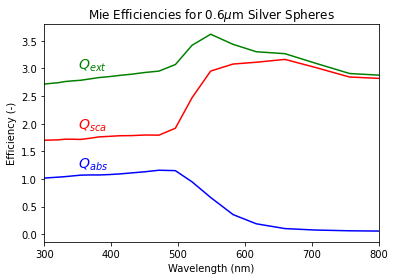

In [6]:
r = 0.3  #radius in microns

x = 2*np.pi*r/ag_lam;
m = ag_mre - 1.0j * ag_mim
qext, qsca, qback, g = miepython.mie(m,x)

plt.plot(ag_lam*1000,qext - qsca,color='blue')
plt.plot(ag_lam*1000,qsca,color='red')
plt.plot(ag_lam*1000,qext,color='green')
plt.text(350, 1.2,'$Q_{abs}$', color='blue', fontsize=14)
plt.text(350, 1.9,'$Q_{sca}$', color='red', fontsize=14)
plt.text(350, 3.0,'$Q_{ext}$', color='green', fontsize=14)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Efficiency (-)")
plt.title("Mie Efficiencies for %.1f$\mu$m Silver Spheres" % (r*2))
plt.xlim(300,800)
plt.show()

## Radiation Pressure

The radiation pressure is given by [e.g., Kerker, p. 94]

$$
Q_{pr}=Q_{ext}-g Q_{sca}
$$

and is the momentum given to the scattering particle [van de Hulst, p. 13] in the direction of the incident wave. The radiation pressure cross section $C_{pr}$ is just the efficiency multiplied by the geometric cross section

$$
C_{pr} = \pi r_0^2 Q_{pr}
$$

The radiation pressure cross section $C_{pr}$ can be interpreted as the area of a black wall that would receive the same force from the same incident wave.  The actual force on the particle is
is

$$
F = E_0 \frac{C_{pr}}{c}
$$

where $E_0$ is the irradiance (W/m$^2$) on the sphere and $c$ is the velocity of the radiation in the medium


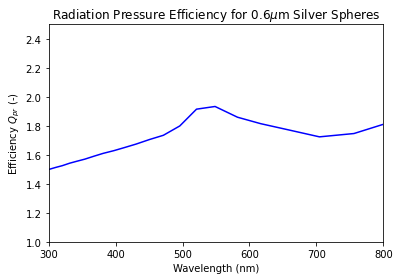

In [7]:
r = 0.3  #radius in microns

x = 2*np.pi*r/ag_lam;
m = ag_mre - 1.0j * ag_mim
qext, qsca, qback, g = miepython.mie(m,x)
qpr  = qext - g*qsca

plt.plot(ag_lam*1000,qpr,color='blue')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Efficiency $Q_{pr}$ (-)")
plt.title("Radiation Pressure Efficiency for %.1f$\mu$m Silver Spheres" % (r*2))
plt.xlim(300,800)
plt.ylim(1,2.5)
plt.show()

## Graph of backscattering efficiency

van de Hulst has a nice graph of backscattering efficiency that we can replicate

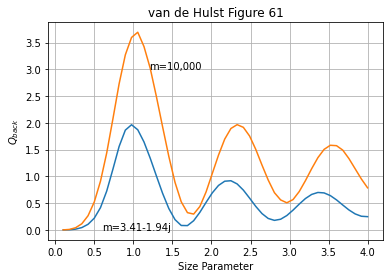

In [8]:
x = np.linspace(0.1,4,50)

m = 3.41-1.94j
qext, qsca, qback, g = miepython.mie(m,x)
plt.plot(x,qback)
plt.text(0.6,0,"m=3.41-1.94j")

m = 10000
qext, qsca, qback, g = miepython.mie(m,x)
plt.plot(x,qback)
plt.text(1.2,3.0,"m=10,000")

plt.xlabel("Size Parameter")
plt.ylabel(r"$Q_{back}$")
plt.title("van de Hulst Figure 61")
plt.grid(True)
plt.show()